Speck 2e 中的读出层是后处理层，如果配置正确，如果发生中断，则可以通过 4 个读出引脚读取输出结果。

读出层用于从芯片中读出分类结果。它由慢速时钟驱动。

它有15个通道（类别id），每个通道的索引从1到15开始。在每个通道中，我们在每个时钟输入（clock_slow）时计数每个通道的输入神经元的事件数量（计数器为16bit） ，所有通道并行计算。

我们将1 个时钟周期内的计数值存储在 16 位寄存器中。然后在下一个时钟周期，我们计算该神经元上的事件并计算该时钟周期内的总事件。然后我们将其放入另一个寄存器中。

然后我们在每个时钟周期执行此操作，并计算1、16 或 32 个时钟周期内事件的平均值（这取决于配置寄存器）。这样我们就可以得到每个通道的平均值（16 位）。

然后所有 15 通道的平均信号进入“查找最大平均值”块。

该块找到最大尖峰神经元的平均值并输出平均信息（16 位），并且还输出最大尖峰神经元的索引。

然后我们有另一个名为“平均选择”的块

该块还接收所有通道的平均输出，此外它还有一个名为AVERAGE_SEL的输入，可以通过 S2P 接口或通过配置寄存器进行设置。然后该模块输出 AVERAGE_SEL<3:0> 位指向的神经元的平均值

最后我们还有另一个名为“阈值比较”的块

该模块与其他模块类似，接收所有通道的平均输出作为输入，将每个通道的平均值（16 位）与配置寄存器设置的阈值（16 位）进行比较，该模块的输出为称为threshold_compare<15:1>

因此，我们将每个通道用一位表示作为threshold_compare。如果通道的平均输出大于阈值，则阈值比较的相应位变为“1”（average_X[15:0] >阈值<15:0> –>阈值_比较_X=1）



In [1]:
import torch
import samna
import samnagui
import time
import random
import copy
import matplotlib.pyplot as plt

from torch import nn
from sinabs.backend.dynapcnn import DynapcnnNetwork
from multiprocessing import Process
from sinabs.from_torch import from_model
from sinabs.layers.pool2d import SumPool2d
from typing import Union
from matplotlib.ticker import MaxNLocator

创建一个可以部署到 devkit 的 1 层 CNN

In [2]:
# init a cnn it has 2 out_channels for a binary classification task
# the input shape of this cnn is (1, 16, 16), output shape of this cnn is (2, 1, 1)

input_shape = (1, 16, 16)

cnn = nn.Sequential(SumPool2d(kernel_size=(1, 1)),
                    nn.Conv2d(in_channels=1,
                              out_channels=2,
                              kernel_size=(16, 16),
                              stride=(1, 1),
                              padding=(0, 0),
                              bias=False),
                    nn.ReLU())

为 CNN 层分配手工权重：

这样设计权重的原因是：

我们将创建一堆假输入尖峰 $X[x_0, x_1, …x_{T}]$ 作为 devkit 的输入。

对于带有时间戳 $t$ 的任何输入尖峰 $x_{t}$：

如果$t$，如果$t < 0.5 * T$，尖峰$x_t$的$y$坐标将在范围[0, 7]内，即在输入区域的上半部分。

如果$t$，如果$t > 0.5 * T$，尖峰$x_t$的$y$坐标将在范围[8, 15]内。即在输入区域的下半部分。

基于此

从时间 $0$ 到 $0.5 * T$ 的输出尖峰将全部来自输出通道 #0

从时间 $0.5 * T$ 到 $T$ 的输出尖峰将全部来自输出通道 #1

In [3]:
# set handcraft weights for the CNN
weight_ones = torch.ones(1, 8, 16, dtype=torch.float32)
weight_zeros = torch.zeros(1, 8, 16, dtype=torch.float32)

channel_1_weight = torch.cat([weight_ones, weight_zeros], dim=1).unsqueeze(0)
channel_2_weight = torch.cat([weight_zeros, weight_ones], dim=1).unsqueeze(0)
handcraft_weight = torch.cat([channel_1_weight, channel_2_weight], dim=0)

output_cnn_lyr_id = 1
cnn[output_cnn_lyr_id].weight.data = handcraft_weight

注意：

对于speck2e devkit，输出通道索引和读出通道索引之间存在错误的映射关系。我们需要定义一个函数来重新映射通道索引。

In [4]:
def remapping_output_index(output_layer: Union[nn.Conv2d, nn.Linear]) -> Union[nn.Conv2d, nn.Linear]:

    """
    Since the mapping of output channel's index from last cnn layer to the readout layer is not correct
    for speck2e devkit.
    We need to remap the index for the channel's index.
    The mapping law is:
    readout_layer_channel <--> cnn_layer_output_channel
       1  <--> 0
       2  <--> 4
       x  <--> 4(x - 1)
          ...
       15 <--> 56
       Args:
           output_layer: Usually we can use both nn.Linear and nn.Conv2d as the output computational layer of
           a classifier. The shape of weights of those two different type layer are:
           nn.Linear -> [output_channel, input_channel]
           nn.Conv2d -> [output_channel, input_channel, *kernel_size]
       Returns:
           new_output_layer: mapped weight of last layer.
    """
    weights = output_layer.weight.data

    out_channel, input_channel, *rest_dims = weights.size()
    new_out_channel = (out_channel - 1) * 4 + 1

    new_weights = torch.zeros(new_out_channel, input_channel, *rest_dims, dtype=weights.dtype, device=weights.device)

    for channel_id in range(out_channel):
        new_weights[channel_id * 4, :] = weights[channel_id, :]

    output_layer.weight.data = new_weights
    
    # change the attributes for the parameter layer
    if isinstance(output_layer, nn.Conv2d):
        output_layer.out_channels = new_out_channel
    elif isinstance(output_layer, nn.Linear):
        output_layer.out_features = new_out_channel
    else:
        raise TypeError(
            f"Expect nn.Conv2d or nn.Linear but got {output_layer.__class__.__name__}"
        )

    return output_layer

# remapping the output layer's 
cnn[output_cnn_lyr_id] = remapping_output_index(cnn[output_cnn_lyr_id])

# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model
# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=False)

按照之前所写过的方法进行配置

In [5]:
readout_threshold = 1

# init devkit config
devkit_cfg = dynapcnn_net.make_config(device="speck2edevkit:0")

# ========== modify devkit config ==========

"""cnn layers configuration"""
# send to output spike from cnn output layer to readout layer as its input
cnn_output_layer = dynapcnn_net.chip_layers_ordering[-1]
# the readout layer id is fixed for speck2e devkit which is 12
readout_layer = 12
print(f'link output layer: {cnn_output_layer} to readout layer: {readout_layer}')
devkit_cfg.cnn_layers[cnn_output_layer].monitor_enable = True
devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].enable = True
devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].layer = readout_layer

"""readout layer configuration"""
devkit_cfg.readout.enable = True
devkit_cfg.readout.readout_configuration_sel = 0b11
devkit_cfg.readout.output_mode_sel = 0b01
devkit_cfg.readout.low_pass_filter_disable = True
devkit_cfg.readout.threshold = readout_threshold


"""dvs layer configuration"""
# link the dvs layer to the 1st layer of the cnn layers
devkit_cfg.dvs_layer.destinations[0].enable = True
devkit_cfg.dvs_layer.destinations[0].layer = dynapcnn_net.chip_layers_ordering[0]
# merge the polarity of input events
devkit_cfg.dvs_layer.merge = True
# drop the raw input events from the dvs sensor, since we write events to devkit manually
devkit_cfg.dvs_layer.pass_sensor_events = False
# enable monitoring the output from dvs pre-preprocessing layer
devkit_cfg.dvs_layer.monitor_enable = True

Network is valid
link output layer: 0 to readout layer: 12


In [7]:
# open devkit
device_names = [each.device_type_name for each in samna.device.get_all_devices()]
print(f"Open device: {device_names[0]}")
devkit = samna.device.open_device(device_names[0])

Open device: Speck2eDevKit


In [8]:
 # init the graph
samna_graph = samna.graph.EventFilterGraph()


# init necessary nodes in samna graph
# node for writing fake inputs into devkit
input_buffer_node = samna.BasicSourceNode_speck2e_event_speck2e_input_event()
# node for reading ReadoutValue 
readout_value_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()
# node for reading ReadoutPinValue
pin_value_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()
# node for reading Spike(i.e. the output from last CNN layer)
spike_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()


# build input branch for graph
samna_graph.sequential([input_buffer_node, devkit.get_model_sink_node()])


# build output branches for graph
# branch #1: for the dvs input visualization
_, _, streamer = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eDvsToVizConverter", "VizEventStreamer"])
# branch #2: for obtaining the ReadoutValue
_, type_filter_node_readout, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eOutputEventTypeFilter", readout_value_buffer_node])
# branch #3: for obtaining the ReadoutPinValue
_, type_filter_node_pin, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eOutputEventTypeFilter", pin_value_buffer_node])
# branch #4: for obtaining the output Spike from cnn output layer
_, type_filter_node_spike, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2eOutputEventTypeFilter", spike_buffer_node])


# set the streamer nodes of the graph
# tcp communication port for dvs input data visualization
streamer_endpoint = 'tcp://0.0.0.0:40000'  
streamer.set_streamer_endpoint(streamer_endpoint)
# add desired type for filter node
type_filter_node_readout.set_desired_type("speck2e::event::ReadoutValue")
type_filter_node_pin.set_desired_type("speck2e::event::ReadoutPinValue")
type_filter_node_spike.set_desired_type("speck2e::event::Spike")


# start samna graph before using the devkit
samna_graph.start()

True

可视化

In [9]:
# init samna node for tcp transmission
samna_node = samna.init_samna()
sender_endpoint = samna_node.get_sender_endpoint()
receiver_endpoint = samna_node.get_receiver_endpoint()
visualizer_id = 3
time.sleep(1)  # wait tcp connection build up, this is necessary to open remote node.

sender_endpoint: tcp://0.0.0.0:57420
receiver_endpoint: tcp://0.0.0.0:57421


In [10]:
# define a function that run the GUI visualizer in the sub-process
def run_visualizer(receiver_endpoint, sender_endpoint, visualizer_id):

    samnagui.runVisualizer(0.6, 0.6, receiver_endpoint, sender_endpoint, visualizer_id)

    return

In [16]:
# create the subprocess
gui_process = Process(target=run_visualizer, args=(receiver_endpoint, sender_endpoint, visualizer_id))
gui_process.start()
print("GUI process started, you should see a window pop up!")

# wait for open visualizer and connect to it.
timeout = 10
begin = time.time()
name = "visualizer" + str(visualizer_id)
while time.time() - begin < timeout:

    try:

        time.sleep(0.05)
        samna.open_remote_node(visualizer_id, name)

    except:
        print("visualizer failed")
        continue

    else:

        visualizer = getattr(samna, name)
        print(f"successful connect the GUI visualizer!")
        break

GUI process started, you should see a window pop up!
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed
visualizer failed


设置读出层的驱动慢时钟

如上所述，芯片的读出层由慢时钟驱动。所以我们需要设置慢时钟的频率，它定义了从开发套件读取分类器结果的频率。

In [17]:
dk_io = devkit.get_io_module()
slow_clk_freq = 20 # Hz
dk_io.set_slow_clk_rate(slow_clk_freq)
dk_io.set_slow_clk(True)

开始 readout

In [18]:
def create_fake_input_events(time_sec: int, data_rate: int = 1000):

    """
    Args:
        time_sec: how long is the input events
        data_rate: how many input events generated in 1 second

        During the first half time, it generates events where y coordinate only in range[0, 7] which means top half
        region of the input feature map.

        Then in the last half of time, it generates events where y coordinate only in range[8, 15] which means bottom
        half region of the input feature map.

    """

    time_offset_micro_sec = 5000  # make the timestamp start from 5000
    time_micro_sec = time_sec * 1000000  # timestamp unit is micro-second
    time_stride = 1000000 // data_rate

    half_time = time_micro_sec // 2

    events = []
    for time_stamp in range(time_offset_micro_sec, time_micro_sec + time_offset_micro_sec + 1, time_stride):

        spk = samna.speck2e.event.DvsEvent()
        spk.timestamp = time_stamp
        spk.p = random.randint(0, 1)
        spk.x = random.randint(0, 15)

        if time_stamp < half_time:
            spk.y = random.randint(0, 7)  # spike located in top half of the input region
        else:
            spk.y = random.randint(8, 15)  # spike located in bottom half of the input region

        events.append(spk)

    return events

In [19]:
# create fake input events
input_time_length = 3 # seconds
data_rate = 5000
input_events = create_fake_input_events(time_sec=3, data_rate=data_rate)

print(f"number of fake input spikes: {len(input_events)}")

number of fake input spikes: 15001


In [20]:
# estimated slow-clock cycle for processing the input spikes
clock_cycles_esitmated = slow_clk_freq * input_time_length
clock_cycles_esitmated

60

读取 Readout Pin Value

In [21]:
# to read the ReadoutPinValue, we need to modify the devkit's readout layer's config a little bit
devkit_cfg.readout.monitor_enable = False
devkit_cfg.readout.readout_pin_monitor_enable = True


# then apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [22]:
# write the fake input into the devkit

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
pin_value_buffer_node.get_events()
spike_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# read the ReadoutPinValue from related buffer node
pin_value_events = pin_value_buffer_node.get_events()

print("You should see the input events through the GUI window!")

You should see the input events through the GUI window!


The estimated clock cycle is 60
Number of ReadoutPinValue events: 60


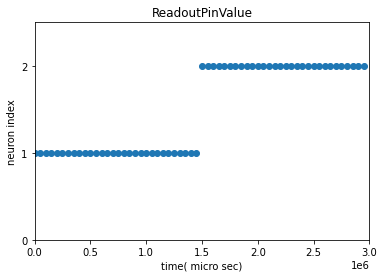

In [23]:
# the number of the ReadoutPinValue should be very close to (or the same as) the estimated clock cycle.
print(f"The estimated clock cycle is {clock_cycles_esitmated}")
print(f"Number of ReadoutPinValue events: {len(pin_value_events)}")

# get the timestamp of the output event
pin_value_timestamp = [each.timestamp for each in pin_value_events]
# shift timestep starting from 0
start_t = pin_value_timestamp[0]
pin_value_timestamp = [each - start_t for each in pin_value_timestamp]

# get the index of the output neuron with maximum output
neuron_id = [each.index for each in pin_value_events]

# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(pin_value_timestamp, neuron_id)
ax.set(xlim=(0, 3e6),ylim=(0, 2.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("ReadoutPinValue")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # make y-axis only show integer

读取 Readout Value

In [24]:
# to read the ReadoutValue, we need to modify the devkit's readout layer's config also

# you can’t monitor any Spike events from CNN layers or the DVS sensor anymore by setting
# `readout.monitor_enable = True`
devkit_cfg.readout.monitor_enable = True
# disable ReadoutPinvalue reading
devkit_cfg.readout.readout_pin_monitor_enable = False


# then re-apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [25]:
# write the fake input into the devkit again

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
readout_value_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# read the buffer immediately after the process waiting finished.
# since every slock-clock cycle will append a new ReadoutValue event into the buffer
readout_value_events = readout_value_buffer_node.get_events()

print("You will not see any input events through the GUI window!")

You will not see any input events through the GUI window!


The estimated clock cycle is 60
Number of ReadoutValue events: 60


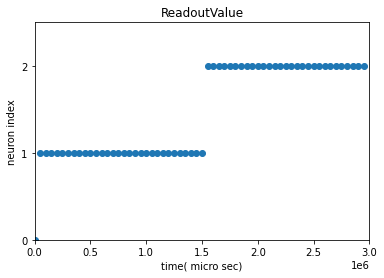

In [26]:
# the number of the ReadoutValue should be very close to (or the same as) the estimated clock cycle.
print(f"The estimated clock cycle is {clock_cycles_esitmated}")
print(f"Number of ReadoutValue events: {len(readout_value_events)}")

# the ReadoutValue event don't have a timestamp, but we know it is generated at every slow-clock cycle
time_each_clock_cycle = 1e6 / slow_clk_freq
readout_value_timestamp = [idx * time_each_clock_cycle for idx in range(len(readout_value_events))]

# shift timestep starting from 0
start_t = readout_value_timestamp[0]
readout_value_timestamp = [each - start_t for each in readout_value_timestamp]

# get the index of the output neuron with maximum output
neuron_id = [(each.value & 0x0F0000) >> 16  for each in readout_value_events]

# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(readout_value_timestamp, neuron_id)
ax.set(xlim=(0, 3e6),ylim=(0, 2.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("ReadoutValue")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

检查输出

number of output spikes from DynacpCNN Layer: 15001


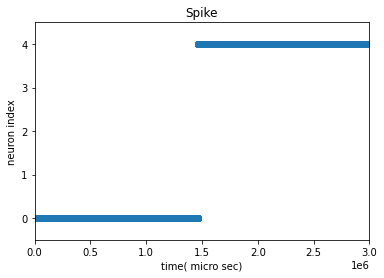

In [27]:
# get the output events from last DynapCNN Layer
dynapcnn_layer_events = spike_buffer_node.get_events()

# eliminate the Spikes come from layer 13
# since the input DVSEvents will be converted into Spikes and output from layer 13
# so the Spikes from layer 13 is the input itself
dynapcnn_layer_events = [each for each in dynapcnn_layer_events if each.layer != 13]

print(f"number of output spikes from DynacpCNN Layer: {len(dynapcnn_layer_events)}")

# get the timestamp of the output event
spike_timestamp = [each.timestamp for each in dynapcnn_layer_events]
# shift timestep starting from 0
start_t = spike_timestamp[0]
spike_timestamp = [each - start_t for each in spike_timestamp]

# get the neuron index of each output spike 
neuron_id = [each.feature  for each in dynapcnn_layer_events]


# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(spike_timestamp, neuron_id)
ax.set(xlim=(0, 3e6),ylim=(-0.5, 4.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("Spike")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# we should see the neuron index are 0 and 4 if using speck2e, because of the incorrect map relationship on speck2e devkit

In [28]:
# stop devkit when experiment finished.

gui_process.terminate()
gui_process.join()

samna_graph.stop()
samna.device.close_device(devkit)